# Darwin Mini: ZMP trajectory

Learning from Stephane Caron's introductory article: 
https://scaron.info/teaching/prototyping-a-walking-pattern-generator.html

I would like to create a simple program to determine the optimal COM trajectory such that the ZMP contraints are enforced.  If possible, I don't want to depend on `pymanoid`, because it requires OpenRAVE, which is a pain to install (2h to install on an Ubuntu 18.04 VM!)

I found the following optimizer, which seems to be fit my needs:
https://osqp.org/docs/examples/mpc.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pypot.creatures import DarwinMini

darwin = DarwinMini(simulator='dummy')
# darwin = DarwinMini(simulator='vrep')

In [31]:
from darwin_mini.walk import WalkStraight, WalkingState
from darwin_mini.point import Point
from darwin_mini.mpc import LinearPredictiveControl

import numpy as np


FOOT_LENGTH = 0.088
FOOT_WIDTH = 0.048


class ZMPWalking(WalkStraight):

    def __init__(self, robot, distance, step_duration, frequency=50):
        WalkStraight.__init__(self, robot, distance, step_duration, frequency)
        
        self.mpc_timestep = 3 * self.dt
        self.preview_time = self.mpc_timestep  # to force MPC update at start
        self.com = Point(np.array([0., 0., 0.098]))
        self.com_jerk = [0., 0., 0.]
        # for plotting later
        self.com_points = []
        self.zmp_points = []
        self.footsteps = []

    def get_support_bounds(self):
        l, w = .8 * FOOT_LENGTH, .7 * FOOT_WIDTH
        L = (1. if self.current_step == 0 else 0.5) * self.current_step_length
        stable_foot_pos = self.pos[self.stable_side + '_foot']
        cur_min = (stable_foot_pos[0] - l/2, stable_foot_pos[1] - w/2)
        cur_max = (stable_foot_pos[0] + l/2, stable_foot_pos[1] + w/2)
        next_min = (stable_foot_pos[0] + L - l/2, -stable_foot_pos[1] - w/2)
        next_max = (stable_foot_pos[0] + L + l/2, -stable_foot_pos[1] + w/2)
        return cur_min, cur_max, next_min, next_max
    
    def get_zmp(self, com):
        h = com.p[2]  # z
        g = 9.80665  # m/s2 (ISO 80000-3)
        zmp_from_state = np.array([1., 0., -h / g])
        return [com.p[0] - (h / g) * com.pdd[0],
                com.p[1] - (h / g) * com.pdd[1]]

    def update_mpc(self, dsp_duration, ssp_duration):
        print("update_mpc(): dsp_duration={}, ssp_duration={}".format(dsp_duration, ssp_duration))
        nb_preview_steps = 16
        T = self.mpc_timestep
        nb_init_dsp_steps = int(round(dsp_duration / T))
        nb_init_ssp_steps = int(round(ssp_duration / T))
        nb_dsp_steps = int(round(self.dsp_duration / T))
        A = np.array([[1., T, T ** 2 / 2.], [0., 1., T], [0., 0., 1.]])
        B = np.array([T ** 3 / 6., T ** 2 / 2., T]).reshape((3, 1))
        h = self.com.p[2]  # z
        g = 9.80665  # m/s2 (ISO 80000-3)
        zmp_from_state = np.array([1., 0., -h / g])
        C = np.array([zmp_from_state, -zmp_from_state])
        D = None
        e = [[], []]
        cur_min, cur_max, next_min, next_max = self.get_support_bounds()
        # print("  update_mpc(): cur_min={}, cur_max={}, next_min={}, next_max={}".format(
        #     cur_min, cur_max, next_min, next_max))
        for k in [0, 1]:
            e[k] = [
                np.array([1000., 1000.]) if i < nb_init_dsp_steps else
                np.array([cur_max[k], -cur_min[k]]) if i - nb_init_dsp_steps <= nb_init_ssp_steps else
                np.array([1000., 1000.]) if i - nb_init_dsp_steps - nb_init_ssp_steps < nb_dsp_steps else
                np.array([next_max[k], -next_min[k]])
                for i in range(nb_preview_steps)]
        print("  update_mpc(): e = {}".format(e))
        if self.current_step >= len(self.footsteps):
            self.footsteps.append(self.swing_target[:2])
        print("update_mpc(): com=({:.3f},{:.3f}), target=({:.3f}, {:.3f})".format(
            self.com.p[0], self.com.p[1], self.swing_target[0], self.swing_target[1]))
        self.x_mpc = LinearPredictiveControl(
            A, B, C, D, e[0],
            x_init=np.array([self.com.p[0], self.com.pd[0], self.com.pdd[0]]),
            x_goal=np.array([self.swing_target[0], 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.y_mpc = LinearPredictiveControl(
            A, B, C, D, e[1],
            x_init=np.array([self.com.p[1], self.com.pd[1], self.com.pdd[1]]),
            x_goal=np.array([self.swing_target[1], 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.x_mpc.solve()
        self.y_mpc.solve()
        self.preview_time = 0.

    def run_com_mpc(self, t):
        # p = np.array(self.pos['pelvis'])
        # p[0] = self.com.p[0]  # keep x
        # p[1] = self.com.p[1]  # keep y
        # self.com.set_pos(p)
        if self.preview_time >= self.mpc_timestep:
            if self.state == WalkingState.DOUBLE_SUPPORT:
                self.update_mpc(self.dsp_duration - t, self.ssp_duration)
            else:  # self.state == WalkingState.SINGLE_SUPPORT:
                self.update_mpc(0., self.step_duration - t)
        # com_jerk = [self.x_mpc.U[0][0], self.y_mpc.U[0][0], 0.]
        pdddx, pdddy = self.x_mpc.U[0][0], self.y_mpc.U[0][0]
        print("run_com_mpc(): u = {}, {}".format(pdddx, pdddy))
        if pdddx is not None:
            self.com_jerk[0] = pdddx
        if pdddy is not None:
            self.com_jerk[1] = pdddy
        print("run_com_mpc(): com_jerk = {:.3f}, {:.3f}".format(self.com_jerk[0], self.com_jerk[1]))
        self.com.integrate_constant_jerk(np.array(self.com_jerk), self.dt)
        print("run_com_mpc(): com = {:.3f}, {:.3f}, {:.3f}".format(self.com.p[0], self.com.p[1], self.com.p[2]))
        self.com_points.append(self.com.p[:2])
        self.zmp_points.append(self.get_zmp(self.com))
        self.preview_time += self.dt

    def update_position(self, t):
        super().update_position(t)
        self.run_com_mpc(t)

In [32]:
w = ZMPWalking(darwin, 1.0, 1.0)

w.start()


*** Start step 1 ***
 >> start double support phase <<
update_mpc(): dsp_duration=0.24934887886047363, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.000,0.000), target=(0.05

  update_mpc(): e = [[array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.000,0.025), target=(0.050, -0.032)
run_com_mpc(): u = 0.1177535818674813, -0.9188281276208607
run_com_mpc(): com_jerk = 0.118, -0.919
ru

run_com_mpc(): u = 0.08755987122994198, -0.022014743420975296
run_com_mpc(): com_jerk = 0.088, -0.022
run_com_mpc(): com = 0.004, 0.032, 0.098
run_com_mpc(): u = 0.08755987122994198, -0.022014743420975296
run_com_mpc(): com_jerk = 0.088, -0.022
run_com_mpc(): com = 0.005, 0.030, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.12745285034179688
  update_mpc(): e = [[array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([0.0352, 0.0352]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([

 >> start single support phase <<
run_com_mpc(): u = -0.07951976962143668, 2.0027654738583163
run_com_mpc(): com_jerk = -0.080, 2.003
run_com_mpc(): com = 0.015, -0.013, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.7174537181854248
  update_mpc(): e = [[array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.

run_com_mpc(): u = 0.09630773514766397, 0.7837905407027439
run_com_mpc(): com_jerk = 0.096, 0.784
run_com_mpc(): com = 0.030, -0.041, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.30528879165649414
  update_mpc(): e = [[array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([ 0.0852, -0.0148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.04

run_com_mpc(): u = -1.6730258821556991, -2.242068204405991
run_com_mpc(): com_jerk = -1.673, -2.242
run_com_mpc(): com = 0.053, -0.011, 0.098
update_mpc(): dsp_duration=0.1434648036956787, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([ 0.09645849, -0.02605849]), array([1000., 1000.])], [array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.

update_mpc(): dsp_duration=0.0, ssp_duration=0.49776387214660645
  update_mpc(): e = [[array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.083,0.040), target=(0.150, -0.032)
run_com_mpc():

  update_mpc(): e = [[array([ 0.1352, -0.0648]), array([ 0.1352, -0.0648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.105,0.033), target=(0.150, -0.032)
run_com_mpc(): u = 0.040062994264431204, -2.1228429646786915
run_com_mpc(): com

  update_mpc(): e = [[array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.2352, -0.1648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.119,-0.021), target=(0.200, 0.032)
run_com_mpc(): u = 0.4978489537726294, 0.6756782659301609
run_com_mpc(): com_je

update_mpc(): dsp_duration=0.0, ssp_duration=0.2661440372467041
  update_mpc(): e = [[array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([ 0.1852, -0.1148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.132,-0.044), target=(0.200, 0.032)
run_com_mpc(): 

update_mpc(): dsp_duration=0.10355591773986816, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([ 0.20002778, -0.12962778]), array([1000., 1000.])], [array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, 

update_mpc(): dsp_duration=0.0, ssp_duration=0.44130897521972656
  update_mpc(): e = [[array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([ 0.2352, -0.1648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.181,0.039), target=(0.250, -0.032)
run_com_mpc():

run_com_mpc(): u = 0.005820809449065067, 1.8245415799294913
run_com_mpc(): com_jerk = 0.006, 1.825
run_com_mpc(): com = 0.205, 0.023, 0.098
run_com_mpc(): u = 0.005820809449065067, 1.8245415799294913
run_com_mpc(): com_jerk = 0.006, 1.825
run_com_mpc(): com = 0.206, 0.021, 0.098

*** Start step 6.0 ***
 >> start double support phase <<
update_mpc(): dsp_duration=0.23471975326538086, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425]), array([ 0.24641425, -0.17601425])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 

run_com_mpc(): u = 0.38101753392794, 1.0954391665884358
run_com_mpc(): com_jerk = 0.381, 1.095
run_com_mpc(): com = 0.221, -0.028, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.5798797607421875
  update_mpc(): e = [[array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000.

update_mpc(): dsp_duration=0.0, ssp_duration=0.17633986473083496
  update_mpc(): e = [[array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([ 0.2852, -0.2148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.237,-0.037), target=(0.300, 0.032)
run_com_mpc():

  update_mpc(): e = [[array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([ 0.3007135, -0.2303135]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])]]
update_mpc(): com=(0.260,0.005), target=(0.350, -0.032)
r

  update_mpc(): e = [[array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([ 0.3352, -0.2648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.284,0.015), target=(0.350, -0.032)
run_com_mpc(): u = -0.017409906286777254, 0.07937616737609626
run_com_mpc(): co

run_com_mpc(): u = -0.5198712427732917, 1.5276027491446686
run_com_mpc(): com_jerk = -0.520, 1.528
run_com_mpc(): com = 0.306, 0.007, 0.098
run_com_mpc(): u = -0.5198712427732917, 1.5276027491446686
run_com_mpc(): com_jerk = -0.520, 1.528
run_com_mpc(): com = 0.307, 0.004, 0.098
update_mpc(): dsp_duration=0.14284467697143555, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([ 0.34530284, -0.27490284]), array([1000., 1000.])], [array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array(

run_com_mpc(): u = 0.08162441166183693, 0.5062979724325538
run_com_mpc(): com_jerk = 0.082, 0.506
run_com_mpc(): com = 0.328, -0.039, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.49275803565979004
  update_mpc(): e = [[array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.04

run_com_mpc(): u = 0.6946210767815869, 1.2415965539090468
run_com_mpc(): com_jerk = 0.695, 1.242
run_com_mpc(): com = 0.347, -0.033, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.08062171936035156
  update_mpc(): e = [[array([ 0.3852, -0.3148]), array([ 0.3852, -0.3148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.048

run_com_mpc(): u = -0.05161299453450021, -1.1816078510960741
run_com_mpc(): com_jerk = -0.052, -1.182
run_com_mpc(): com = 0.368, 0.021, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6731278896331787
  update_mpc(): e = [[array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.4852, -0.4148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), ar

update_mpc(): dsp_duration=0.0, ssp_duration=0.26624107360839844
  update_mpc(): e = [[array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([ 0.4352, -0.3648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.390,0.044), target=(0.450, -0.032)
run_com_mpc():

update_mpc(): dsp_duration=0.10410881042480469, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([ 0.45016014, -0.37976014]), array([1000., 1000.])], [array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152, 

update_mpc(): dsp_duration=0.0, ssp_duration=0.4351358413696289
  update_mpc(): e = [[array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([ 0.4852, -0.4148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.427,-0.039), target=(0.500, 0.032)
run_com_mpc(): 

run_com_mpc(): u = 2.6136450155345634, 3.9693473016853313
run_com_mpc(): com_jerk = 2.614, 3.969
run_com_mpc(): com = 0.448, -0.025, 0.098
run_com_mpc(): u = 2.6136450155345634, 3.9693473016853313
run_com_mpc(): com_jerk = 2.614, 3.969
run_com_mpc(): com = 0.449, -0.023, 0.098

*** Start step 11.0 ***
 >> start double support phase <<
run_com_mpc(): u = 2.6136450155345634, 3.9693473016853313
run_com_mpc(): com_jerk = 2.614, 3.969
run_com_mpc(): com = 0.450, -0.020, 0.098
update_mpc(): dsp_duration=0.21623778343200684, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975318, -0.4271318]), array([ 0.4975

run_com_mpc(): u = -0.011736515458686564, 1.004331912692852
run_com_mpc(): com_jerk = -0.012, 1.004
run_com_mpc(): com = 0.474, 0.025, 0.098
run_com_mpc(): u = -0.011736515458686564, 1.004331912692852
run_com_mpc(): com_jerk = -0.012, 1.004
run_com_mpc(): com = 0.476, 0.026, 0.098
run_com_mpc(): u = -0.011736515458686564, 1.004331912692852
run_com_mpc(): com_jerk = -0.012, 1.004
run_com_mpc(): com = 0.477, 0.027, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.5570628643035889
  update_mpc(): e = [[array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488,

run_com_mpc(): u = 0.011913934821874089, 0.10795860250567176
run_com_mpc(): com_jerk = 0.012, 0.108
run_com_mpc(): com = 0.500, 0.027, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.16183185577392578
  update_mpc(): e = [[array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([ 0.5352, -0.4648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0

run_com_mpc(): u = 0.06790096520321423, 6.718732469367459
run_com_mpc(): com_jerk = 0.068, 6.719
run_com_mpc(): com = 0.516, -0.012, 0.098
update_mpc(): dsp_duration=0.003797769546508789, ssp_duration=0.75
  update_mpc(): e = [[array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([ 0.54640971, -0.47600971]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), arr

run_com_mpc(): u = 0.1232382682633407, 0.31251130770409763
run_com_mpc(): com_jerk = 0.123, 0.313
run_com_mpc(): com = 0.530, -0.043, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.3452470302581787
  update_mpc(): e = [[array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([ 0.5852, -0.5148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.048

update_mpc(): dsp_duration=0.19495272636413574, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906]), array([ 0.5992906, -0.5288906])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.

  update_mpc(): e = [[array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.580,0.035), target=(0.650, -0.032)
run_com_mpc(): u = -0.06563016606583529, -0.241871351810851
run_com_mpc(): com_

run_com_mpc(): u = -0.014724539938984524, 0.47219248289547755
run_com_mpc(): com_jerk = -0.015, 0.472
run_com_mpc(): com = 0.609, 0.035, 0.098
run_com_mpc(): u = -0.014724539938984524, 0.47219248289547755
run_com_mpc(): com_jerk = -0.015, 0.472
run_com_mpc(): com = 0.610, 0.033, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.07107996940612793
  update_mpc(): e = [[array([ 0.6352, -0.5648]), array([ 0.6352, -0.5648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), a

run_com_mpc(): u = 0.08542756232245584, 1.1290633824383964
run_com_mpc(): com_jerk = 0.085, 1.129
run_com_mpc(): com = 0.628, -0.018, 0.098
run_com_mpc(): u = 0.08542756232245584, 1.1290633824383964
run_com_mpc(): com_jerk = 0.085, 1.129
run_com_mpc(): com = 0.629, -0.021, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.6612148284912109
  update_mpc(): e = [[array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.7352, -0.6648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488

run_com_mpc(): u = 0.17499825724151857, 0.6684901626595324
run_com_mpc(): com_jerk = 0.175, 0.668
run_com_mpc(): com = 0.642, -0.043, 0.098
run_com_mpc(): u = 0.17499825724151857, 0.6684901626595324
run_com_mpc(): com_jerk = 0.175, 0.668
run_com_mpc(): com = 0.642, -0.043, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.24399280548095703
  update_mpc(): e = [[array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([ 0.6852, -0.6148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([

run_com_mpc(): u = -0.12594784032799702, -2.173946835774854
run_com_mpc(): com_jerk = -0.126, -2.174
run_com_mpc(): com = 0.658, -0.008, 0.098
run_com_mpc(): u = -0.12594784032799702, -2.173946835774854
run_com_mpc(): com_jerk = -0.126, -2.174
run_com_mpc(): com = 0.659, -0.005, 0.098
update_mpc(): dsp_duration=0.08336687088012695, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([ 0.70009711, -0.62969711]), array([1000., 1000.]), array([1000., 1000.])], [array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152

run_com_mpc(): u = 0.033877162294726856, 0.8450577610548807
run_com_mpc(): com_jerk = 0.034, 0.845
run_com_mpc(): com = 0.677, 0.015, 0.098
run_com_mpc(): u = 0.033877162294726856, 0.8450577610548807
run_com_mpc(): com_jerk = 0.034, 0.845
run_com_mpc(): com = 0.678, 0.015, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.4229257106781006
  update_mpc(): e = [[array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([ 0.7352, -0.6648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152

run_com_mpc(): u = 1.3646169912634842, -5.907708339337026
run_com_mpc(): com_jerk = 1.365, -5.908
run_com_mpc(): com = 0.698, 0.013, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.019369840621948242
  update_mpc(): e = [[array([ 0.7352, -0.6648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148])], [array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.01

run_com_mpc(): u = -0.025949852450584548, 0.8984593747713486
run_com_mpc(): com_jerk = -0.026, 0.898
run_com_mpc(): com = 0.725, -0.031, 0.098
run_com_mpc(): u = -0.025949852450584548, 0.8984593747713486
run_com_mpc(): com_jerk = -0.026, 0.898
run_com_mpc(): com = 0.726, -0.033, 0.098
run_com_mpc(): u = -0.025949852450584548, 0.8984593747713486
run_com_mpc(): com_jerk = -0.026, 0.898
run_com_mpc(): com = 0.727, -0.035, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.5647828578948975
  update_mpc(): e = [[array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0

  update_mpc(): e = [[array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([ 0.7852, -0.7148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.746,-0.042), target=(0.800, 0.032)
run_com_mpc(): u = 0.0005646293315424756, -0.6337978788782888
run_com_mpc(): co

update_mpc(): dsp_duration=0.05877375602722168, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([ 0.80025138, -0.72985138]), array([1000., 1000.]), array([1000., 1000.])], [array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000.

update_mpc(): dsp_duration=0.0, ssp_duration=0.3885219097137451
  update_mpc(): e = [[array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([ 0.8352, -0.7648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.777,0.043), target=(0.850, -0.032)
run_com_mpc(): 

update_mpc(): dsp_duration=0.2256457805633545, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674]), array([ 0.8525674, -0.7821674])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update

  update_mpc(): e = [[array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.823,-0.013), target=(0.900, 0.032)
run_com_mpc(): u = -0.04487031149593633, -1.4464676131354472
run_com_mpc(): com

update_mpc(): dsp_duration=0.0, ssp_duration=0.15118885040283203
  update_mpc(): e = [[array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([ 0.8852, -0.8148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152])]]
update_mpc(): com=(0.846,-0.015), target=(0.900, 0.032)
run_com_mpc():

  update_mpc(): e = [[array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])]]
update_mpc(): com=(0.864,0.013), target=(0.950, -0.032)
run_com_mpc(): u = 0.04104664209837076, -1.5102495608325188
run_com_mpc(): com_

  update_mpc(): e = [[array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([ 0.9352, -0.8648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.880,0.044), target=(0.950, -0.032)
run_com_mpc(): u = 0.048714563485879214, -0.23098222324744605
run_com_mpc(): co

  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942]), array([ 0.94602942, -0.87562942])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.901,0.016)

run_com_mpc(): u = -0.012510543519794531, 0.3542621815736601
run_com_mpc(): com_jerk = -0.013, 0.354
run_com_mpc(): com = 0.930, -0.038, 0.098
run_com_mpc(): u = -0.012510543519794531, 0.3542621815736601
run_com_mpc(): com_jerk = -0.013, 0.354
run_com_mpc(): com = 0.932, -0.039, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.4624819755554199
  update_mpc(): e = [[array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  

run_com_mpc(): u = 0.009658080257509373, -1.5004027170255108
run_com_mpc(): com_jerk = 0.010, -1.500
run_com_mpc(): com = 0.952, -0.033, 0.098
run_com_mpc(): u = 0.009658080257509373, -1.5004027170255108
run_com_mpc(): com_jerk = 0.010, -1.500
run_com_mpc(): com = 0.953, -0.031, 0.098
update_mpc(): dsp_duration=0.0, ssp_duration=0.05991983413696289
  update_mpc(): e = [[array([ 0.9852, -0.9148]), array([ 0.9852, -0.9148]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648])], [array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), a

update_mpc(): dsp_duration=0.0, ssp_duration=0.6553027629852295
  update_mpc(): e = [[array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.0602, -0.9898])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.968,0.021), target=(1.000, -0.032)
run_com_mpc(): 

  update_mpc(): e = [[array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([ 1.0352, -0.9648]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.0602, -0.9898]), array([ 1.0602, -0.9898]), array([ 1.0602, -0.9898]), array([ 1.0602, -0.9898]), array([ 1.0602, -0.9898]), array([ 1.0602, -0.9898]), array([ 1.0602, -0.9898]), array([ 1.0602, -0.9898])], [array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([ 0.0488, -0.0152]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488]), array([-0.0152,  0.0488])]]
update_mpc(): com=(0.978,0.041), target=(1.000, -0.032)
run_com_mpc(): u = 0.034168633840446196, 0.6155934895074648
run_com_mpc(): com_

In [10]:
w.footsteps

[(0.05000000000000002, -0.032),
 (0.10000000000000003, 0.032),
 (0.15000000000000002, -0.032),
 (0.2, 0.032),
 (0.25000000000000006, -0.032),
 (0.3, 0.032),
 (0.35000000000000003, -0.032),
 (0.4000000000000001, 0.032),
 (0.45, -0.032),
 (0.5, 0.032),
 (0.55, -0.032),
 (0.6000000000000001, 0.032),
 (0.6499999999999999, -0.032),
 (0.7, 0.032),
 (0.75, -0.032),
 (0.8, 0.032),
 (0.8499999999999999, -0.032),
 (0.9000000000000001, 0.032),
 (0.95, -0.032),
 (1.0, 0.032),
 (0.9999999999999991, -0.032)]

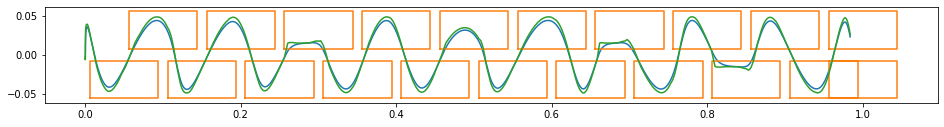

In [33]:
fig = plt.figure(figsize=(16, 2))
ax = fig.subplots(1, 1)
ax.set_aspect('equal')
x, y = zip(*w.com_points)
ax.plot(x, y)
sole = None
for fs in w.footsteps:
    s = np.array([[-0.044, -.024], [0.044, -.024], [0.044, .024], [-0.044, .024], [-0.044, -.024]]) + fs
    if sole is None:
        sole = s
    else:
        sole = np.vstack([sole, np.array([np.nan, np.nan]), s])
xs, ys = zip(*sole)
ax.plot(xs, ys)
x, y = zip(*w.zmp_points)
ax.plot(x, y)
